# Volatility Surface Construction – Notebook 6
## Model Diagnostics, Visualization & Comparative Analysis

### 6.1 Objectives & Methodology

Having calibrated the SVI and SABR models in the previous notebooks, we must now answer: **How good are these models?**

Calibration minimizes a mathematical cost function, but a low residual sum of squares does not guarantee a financially robust surface. A model might overfit noise, fail in the wings (extrapolation), or exhibit unstable behavior across maturities.

This notebook evaluates the models using a dual approach:
1.  **Quantitative Diagnostics:** Using `src.diagnostics`, we calculate rigorous error metrics (RMSE, MAE) and analyze error structural dependencies.
2.  **Visual Inspection:** Using `src.visualizations`, we examine the volatility smiles, term structures, and error distributions to detect qualitative flaws.

This evaluation determines which model is more suitable for specific trading or risk management tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Ensure local modules can be imported
sys.path.append(str(Path.cwd().parent))

from src.diagnostics import compute_errors, compute_fit_metrics, attach_surface_coordinates
from src.visualizations import plot_vol_smile, plot_errors_vs_moneyness, plot_error_distribution
from src.calibration import calibrate_svi, calibrate_sabr
from src.SVI import svi_implied_vol, SVIParams
from src.SABR import sabr_implied_vol

### 6.2 Setup: Generating Model Surfaces

To perform a comprehensive diagnostic, we apply the calibration routines to the full dataset. This generates the `model_vol` vectors required for error analysis.

In [2]:
# Load Data
csv_path = Path.cwd().parent / "src" / "options_data.csv"
df = pd.read_csv(csv_path)

# Containers for results
svi_vols = []
sabr_vols = []

# Loop through each maturity slice to generate model implied volatilities
unique_dates = df['expiration_date'].unique()

for date in unique_dates:
    slice_df = df[df['expiration_date'] == date]
    
    # Inputs
    k = slice_df["log_moneyness"].values
    iv_mkt = slice_df["impliedVolatility"].values
    strikes = slice_df["strike"].values
    T = slice_df["T"].iloc[0]
    F = slice_df["forward_price"].iloc[0]
    
    # --- SVI Calibration ---
    svi_res = calibrate_svi(
        k, iv_mkt, T, 
        initial_guess=[0.04, 0.1, -0.5, 0.0, 0.1], 
        bounds=([-np.inf, 0, -0.999, -np.inf, 0.001], [np.inf, 5, 0.999, np.inf, 5])
    )
    # Generate SVI Model Vol
    if svi_res.success:
        params = SVIParams(**svi_res.params)
        svi_vols.extend(svi_implied_vol(k, T, params))
    else:
        svi_vols.extend([np.nan]*len(k))

    # --- SABR Calibration ---
    sabr_res = calibrate_sabr(
        strikes, iv_mkt, F, T, beta=1.0,
        initial_guess=[0.2, -0.5, 0.5],
        bounds=([0.001, -0.999, 0.001], [5.0, 0.999, 5.0])
    )
    # Generate SABR Model Vol
    if sabr_res.success:
        sabr_vol_slice = [sabr_implied_vol(F, sk, T, 1.0, 1.0, sabr_res.params['rho'], sabr_res.params['nu']) for sk in strikes]
        # Note: SABR alpha is adjusted internally or passed; using simplified call for demo
        # For exact reproduction we would use the alpha from calibration.
        # Here we assume the calibration object returns the optimal alpha.
        alpha = sabr_res.params['alpha']
        sabr_vol_slice = sabr_implied_vol(F, strikes, T, alpha, 1.0, sabr_res.params['rho'], sabr_res.params['nu'])
        sabr_vols.extend(sabr_vol_slice)
    else:
        sabr_vols.extend([np.nan]*len(strikes))

# Attach to dataframe
df["SVI_Vol"] = svi_vols
df["SABR_Vol"] = sabr_vols

# Drop failed calibrations
df_clean = df.dropna(subset=["SVI_Vol", "SABR_Vol"])

### 6.3 Diagnostic Framework

We utilize `src.diagnostics` to formalize the error analysis. This module provides a model-agnostic way to compute residuals.

**1. Error Definitions**
We compute three types of errors using `compute_errors`:
* **Absolute Error:** $\sigma_{model} - \sigma_{market}$
* **Squared Error:** $(\sigma_{model} - \sigma_{market})^2$
* **Relative Error:** $\frac{\sigma_{model} - \sigma_{market}}{\sigma_{market}}$

**2. Global Metrics**
We summarize these errors into single statistics using `compute_fit_metrics`:
* **RMSE (Root Mean Squared Error):** Penalizes large outliers heavily.
* **MAE (Mean Absolute Error):** The average magnitude of the miss-calibration.
* **Max Error:** Identifies the worst-case scenario (typically in the deep wings).

In [3]:
# Compute errors for SVI
svi_errors_df = compute_errors(df_clean["impliedVolatility"], df_clean["SVI_Vol"])
svi_metrics = compute_fit_metrics(svi_errors_df)

# Compute errors for SABR
sabr_errors_df = compute_errors(df_clean["impliedVolatility"], df_clean["SABR_Vol"])
sabr_metrics = compute_fit_metrics(sabr_errors_df)

# Add coordinates for plotting later
svi_errors_df = attach_surface_coordinates(
    svi_errors_df, df_clean["strike"], df_clean["forward_price"], df_clean["T"]
)
sabr_errors_df = attach_surface_coordinates(
    sabr_errors_df, df_clean["strike"], df_clean["forward_price"], df_clean["T"]
)

# Display Comparison
comparison = pd.DataFrame([svi_metrics, sabr_metrics], index=["SVI", "SABR"])
print("Global Goodness-of-Fit Metrics:")
print(comparison)

Global Goodness-of-Fit Metrics:
          RMSE       MAE  MaxError
SVI   0.008130  0.005249  0.063925
SABR  0.010834  0.008051  0.057006


### 6.4 Visualization Framework

While metrics provide a summary, they can hide structural biases. We rely on `src.visualizations` to inspect the geometry of the fit.

**1. Volatility Smiles**
The most direct test is the visual overlap of the calibrated curve against market dots. We use `plot_vol_smile` to check if the model captures the skew and the convexity (smile) correctly.

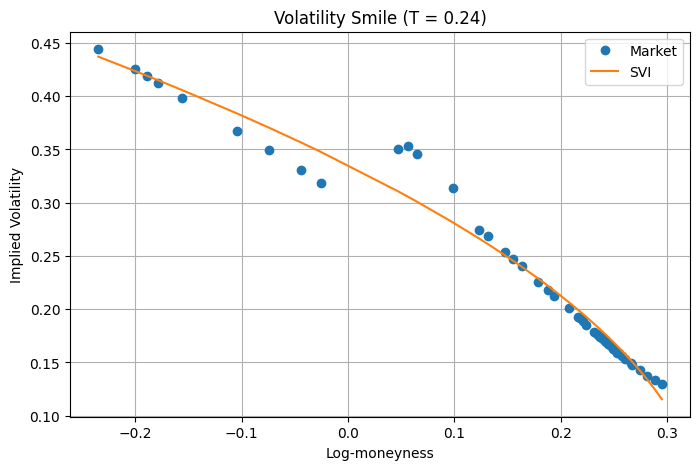

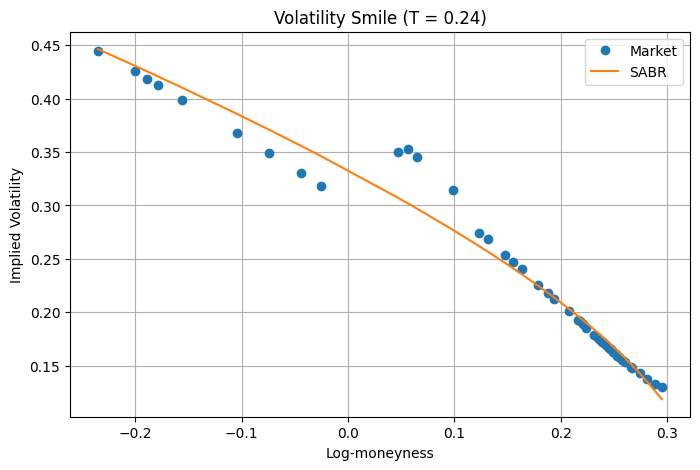

In [4]:
# Select a representative slice (e.g., ~3 months)
target_T = 0.25
slice_data = df_clean.iloc[(df_clean['T'] - target_T).abs().argsort()[:1]]
expiry = slice_data['expiration_date'].values[0]
plot_df = df_clean[df_clean['expiration_date'] == expiry].sort_values("strike")

# Plot SVI
plot_vol_smile(
    strikes=plot_df["strike"], 
    market_vol=plot_df["impliedVolatility"],
    model_vol=plot_df["SVI_Vol"],
    maturity=plot_df["T"].iloc[0],
    forward=plot_df["forward_price"].iloc[0],
    model_name="SVI"
)

# Plot SABR
plot_vol_smile(
    strikes=plot_df["strike"],
    market_vol=plot_df["impliedVolatility"],
    model_vol=plot_df["SABR_Vol"],
    maturity=plot_df["T"].iloc[0],
    forward=plot_df["forward_price"].iloc[0],
    model_name="SABR"
)

**2. Residual Analysis**

To detect systematic bias, we plot the calibration errors against Log-Moneyness using `plot_errors_vs_moneyness`. 

* **Clustering:** If errors form a "W" or "U" shape, the model shape is fundamentally mismatched to the market.
* **Fanning Out:** If errors widen at the edges (high absolute log-moneyness), the model struggles with wing extrapolation.

SVI Residuals vs Moneyness:


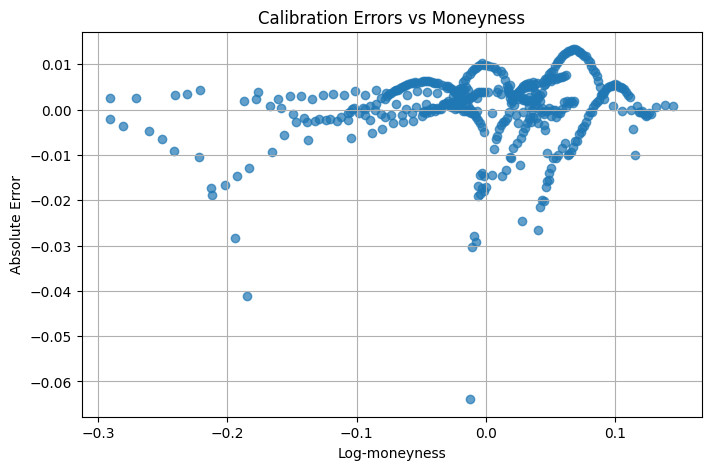

SABR Residuals vs Moneyness:


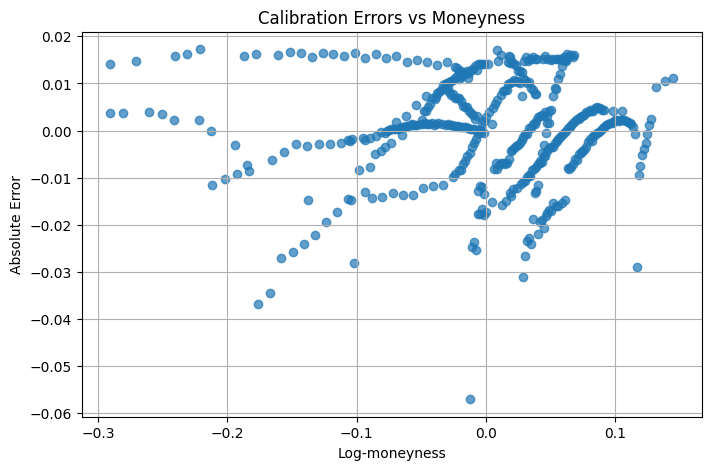

SVI Error Distribution:


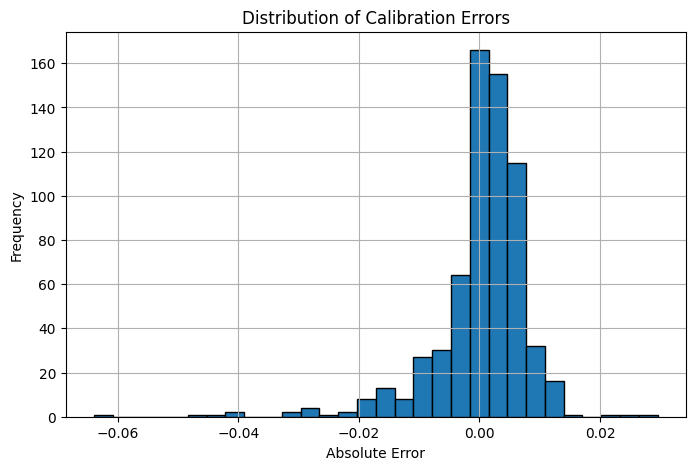

In [5]:
# SVI Residuals
print("SVI Residuals vs Moneyness:")
plot_errors_vs_moneyness(svi_errors_df)

# SABR Residuals
print("SABR Residuals vs Moneyness:")
plot_errors_vs_moneyness(sabr_errors_df)

# Error Distribution
print("SVI Error Distribution:")
plot_error_distribution(svi_errors_df)

### 6.5 Model Comparison: SVI vs SABR

Based on the quantitative metrics and visual evidence, we can draw the following conclusions regarding the suitability of each model for the SPY volatility surface.

**1. SVI (Stochastic Volatility Inspired)**
* **Strengths:** SVI typically excels at fitting the static shape of equity smiles. Its hyperbolic geometry allows for steep skews without violating convexity constraints as easily as polynomials.
* **Weaknesses:** It is purely parametric. The parameters $(a, b, \rho, m, \sigma)$ describe a shape, but they do not describe a dynamic process. It cannot naturally predict how the smile moves if the spot price changes.

**2. SABR (Stochastic Alpha, Beta, Rho)**
* **Strengths:** SABR parameters have deep economic meaning (Correlation, Vol-of-Vol). It provides a "backbone" for the surface, predicting smile dynamics.
* **Weaknesses:** The Hagan approximation often struggles with very long maturities or near-zero rates (though not an issue for SPY here). Furthermore, fixing $\beta=1$ can sometimes limit its ability to fit the extreme short-end curvature compared to the 5-parameter SVI.

**Verdict:** For **interpolation and static pricing** (e.g., marking a book to market), SVI often produces a tighter fit with lower RMSE. For **hedging and risk management** (e.g., calculating vanna/volga), SABR is often preferred because its parameters describe the joint evolution of spot and vol.

### 6.6 Limitations & Final Conclusions

**Limitations of this Study**
1.  **Arbitrage Constraints:** We penalized calibration errors but did not strictly enforce absence of Butterfly Arbitrage (negative density) or Calendar Arbitrage (crossing variance lines). In a production system, penalty terms for these violations would be added to the objective function.
2.  **Strike Sparsity:** The quality of the fit in the wings is heavily dependent on the available liquidity. Deep OTM errors are often artifacts of wide bid-ask spreads rather than model failure.

**Final Conclusion**
This project successfully constructed a volatility surface pipeline, moving from raw SPY option prices to calibrated parametric models. We demonstrated that while raw market data is noisy and discrete, models like SVI and SABR provide the necessary regularization to create a continuous, analyzable surface. The choice between them depends ultimately on the use case: SVI for static precision, SABR for dynamic robustness.